In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('..')
import gym
import yowie_gym

# Car Parking

This task involves steering a robotic car, where one of the control inputs, the angle of the front wheels, is a kinematic, rather than a dynamic variable. When controls specify kinematic variables, bounds arise naturally from the geometry of the problem rather than from actuator limits. This makes kinematic problems an important class for our proposed algorithm.

$(x, y, \theta, v)$ is the 4-dimensional state. $x$, $y$ is the position of the point midway between the back wheels. $\theta$ is the angle of the car relative to the $x$-axis. $v$ is the velocity of the front wheels. The two control signals are $\omega$, the front wheel angle, and $a$ the front wheel acceleration. We follow LaValle's (see Chapter 13, pp. 723-724) characterization to obtain the dynamics

$$
\dot x = v\,\cos\theta\\
\dot y = v\,\sin\theta\\
\dot {\theta} = \frac{v}{d} \tan\omega\\
\dot v = a
$$

where $d$ is the distance between the front and back wheels (in Tassa et al experiments, this value was set to $2$ and we do so too).

A parking task is _encoded_ as a final cost on the distance of the last state from $(0,0,0,0)$, i.e. at the plane, facing east and motionless. Distance was measured using the Huber-like function 

$$
z(x,p) = \sqrt{(x^2+p^2)} - p
$$

This function is roughly quadratic in $p$-sized neighbourhood of the origina and linear thereafter. The terminal cost is given by

$$
l_f(\mathbf{x}) = z(x,px) + z(y,py) + z(\theta,p_{\theta}) + z(v,p_v)
$$

Tassa et al chose $p_x = p_y = 0.1m$, $p_{\theta} = 0.01rad$ and $p_v=1m/s$ to compensate for the relative difficulty of changing each variable. According to Tassa et al, it is easier to stop the car ($v=0$) than it is to orient it (\theta=0), and it suited them to have the optimizer to focus on the latter task once close enough to the goal state. 

Tassa et al define the state dependent component of the stage cost as the Cartesian distance from the origin

$$
l(x) = 0.01( z(x,p_x) + z(y,p_y))
$$

in order to encourage parking maneuvers that do no take the car far from the origin. The control dependent component of the stage cost is defined by Tassa as

$$
l(u) = c_{\omega} \omega^2 + c_{a} a^2
$$

setting $c_{\omega}=0.01$ and $c_{a}=10^{-4}$. The cost coefficients were chosen to be small in order to encourage the controller to stay within the bounds

$$
0.5rad \leq \omega \leq 0.5rad \\
-2 m/s^2 \leq a \leq 2 m/s^2
$$

The horizon is set to $1,000$ time steps. Tassa et al do not mention which time step $h$ they use to discretize the dynamics, we chose $0.01$.

### Initial States

Initial states correspond to the set $X_0 \times Y_0 \times \theta_0 \times a_0$, where 
- $X_0$ = $Y_0$ = $\{-4, -3, \ldots, 0, \ldots, 4\}$, 
- $\theta_0$ = $\{ 0, \frac{\pi}{2}, \pi, \frac{3\pi}{2} \}$, and

- $a_0$ = \{ -1, -0.5, 0, 0.5, 1\}

## Task 000

In [3]:
env = gym.make('CarPark-5532-v1')

In [4]:
x0 = env.reset()

In [5]:
print(x0)

[[1.        ]
 [1.        ]
 [4.71238898]
 [0.        ]]


This initial situation corresponds with the car on the lower left corner of the lattice, oriented towards the right, while moving backwards.

### Passive Dynamics ($U$ $=$ 0)

In [6]:
x0 = env.reset()
S_zero = [x0]
g_zero = []
k = 0
while True:
    u = np.zeros(env.action_space.shape)
    x, r, done, info = env.step(u)
    S_zero.append(x)
    g_zero.append(r)
    if done: break
S_zero = np.hstack(S_zero)
g_zero = np.asarray(g_zero, dtype=np.float64)
J_zero = np.asarray([ np.sum(g_zero[k:]) for k in range(g_zero.shape[0])], dtype=np.float64)

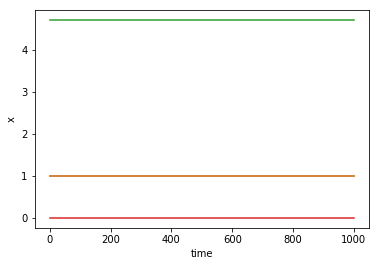

In [7]:
plt.xlabel('time')
plt.ylabel('x')
for x_dim in range(S_zero.shape[0]):
    # Plot a single line
    xs = np.linspace(0, S_zero.shape[1], num=S_zero.shape[1])
    ys = S_zero[x_dim,:]
    plt.plot(xs, ys)

### Random Excitation

In [8]:
x0 = env.reset()
S_zero = [x0]
g_zero = []
while True:
    u = np.random.normal(0.0, 1.0, size=(env.action_space.shape[0], 1))
    x, r, done, info = env.step(u)
    S_zero.append(x)
    g_zero.append(r)
    if done: break
S_zero = np.hstack(S_zero)
g_zero = np.asarray(g_zero, dtype=np.float64)
J_zero = np.asarray([ np.sum(g_zero[k:]) for k in range(g_zero.shape[0])], dtype=np.float64)

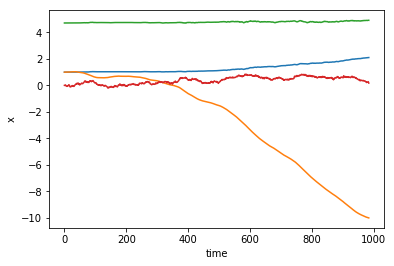

In [9]:
plt.xlabel('time')
plt.ylabel('x')
for x_dim in range(S_zero.shape[0]):
    # Plot a single line
    xs = np.linspace(0, S_zero.shape[1], num=S_zero.shape[1])
    ys = S_zero[x_dim,:]
    plt.plot(xs, ys)

### MPC

Trajectory followed by MPC controller based on Differential Dynamic Programming

In [10]:
print(env.reset())

[[1.        ]
 [1.        ]
 [4.71238898]
 [0.        ]]


In [11]:
x0 = env.reset()
S_mpc = [x0]
U_mpc = []
g_mpc = []
J_mpc = []
pJ_mpc = []
x = x0
while True:
    u, j = env.unwrapped.mpc(x)
    U_mpc.append(u)
    pJ_mpc.append(j)
    #print(u)
    x, r, done, info = env.step(u)
    S_mpc.append(x)
    g_mpc.append(r)
    if done: break

In [12]:
S_mpc = np.hstack(S_mpc)
U_mpc = np.hstack(U_mpc)
g_mpc = np.asarray(g_mpc, dtype=np.float64)
J_mpc = np.asarray([ np.sum(g_mpc[k:]) for k in range(g_mpc.shape[0])], dtype=np.float64)
pJ_mpc = np.array(pJ_mpc)

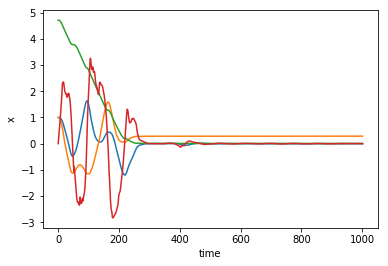

In [13]:
plt.xlabel('time')
plt.ylabel('x')
for x_dim in range(S_mpc.shape[0]):
    # Plot a single line
    xs = np.linspace(0, S_mpc.shape[1], num=S_mpc.shape[1])
    ys = S_mpc[x_dim,:]
    plt.plot(xs, ys)

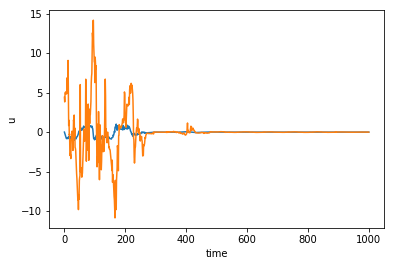

In [14]:
plt.xlabel('time')
plt.ylabel('u')
for x_dim in range(U_mpc.shape[0]):
    # Plot a single line
    xs = np.linspace(0, U_mpc.shape[1], num=U_mpc.shape[1])
    ys = U_mpc[x_dim,:]
    plt.plot(xs, ys)

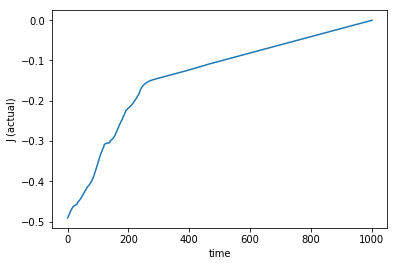

In [15]:
plt.xlabel('time')
plt.ylabel('J (actual)')
# Plot a single line
xs = np.linspace(0, S_mpc.shape[1], num=S_mpc.shape[1]-1)
ys = J_mpc
plt.plot(xs, ys)

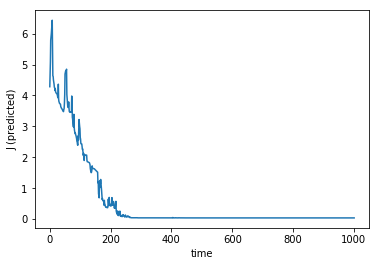

In [16]:
plt.xlabel('time')
plt.ylabel('J (predicted)')
# Plot a single line
xs = np.linspace(0, S_mpc.shape[1], num=S_mpc.shape[1]-1)
ys = pJ_mpc
plt.plot(xs, ys)